## 1. Environment setup:  Import libraries and read data

In [88]:
### Create a requirements_ead.txt
#!pip freeze > /home/ec2-user/SageMaker/requirements_scoopv2.txt

In [89]:
### Add sodapy for future data pipeline
#!pip install sodapy

In [2]:
### Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print(pd.__version__) #curious since it is a prebuild image

from datetime import date
from datetime import time
from datetime import datetime

import seaborn as sns
sns.set()

# data set socrata
#from sodapy import Socrata

1.0.1


### Info about the data set

In [6]:
! tail /home/ec2-user/SageMaker/scores.csv

91572,El Gran Taco Loco,4591 Mission St.,San Francisco,CA,94112,,,,,91572_20190506,05/06/2019 12:00:00 AM,76,Routine - Unscheduled,91572_20190506_103150,Improper or defective plumbing,Low Risk,,,,,,
71067,Bancarella,350 Powell St,San Francisco,CA,94102,,,,,71067_20190503,05/03/2019 12:00:00 AM,94,Routine - Unscheduled,71067_20190503_103120,Moderate risk food holding temperature,Moderate Risk,,,,,,
70137,Reveille Coffee Co.,200 Columbus St,San Francisco,CA,94133,,,,,70137_20190506,05/06/2019 12:00:00 AM,,Reinspection/Followup,,,,,,,,,
96536,PERILLA,510 Mission St,San Francisco,CA,94105,,,,+14155646102,96536_20190502,05/02/2019 12:00:00 AM,80,Routine - Unscheduled,96536_20190502_103145,Improper storage of equipment utensils or linens,Low Risk,,,,,,
91572,El Gran Taco Loco,4591 Mission St.,San Francisco,CA,94112,,,,,91572_20190506,05/06/2019 12:00:00 AM,76,Routine - Unscheduled,91572_20190506_103129,Insufficient hot water or running water,Moderate Risk,,,,,,
89569,Blue Bottle Coffee,2 Sou

### Load data set

In [7]:
missing_values = ["n/a", "na", "--", "unknown", "?", " unknown", " ?"]  
df = pd.read_csv('/home/ec2-user/SageMaker/scores.csv', sep = ',' ,na_values=missing_values, parse_dates=True, index_col = 'inspection_date')  
df.head(3)

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,...,inspection_type,violation_id,violation_description,risk_category,Neighborhoods (old),Police Districts,Supervisor Districts,Fire Prevention Districts,Zip Codes,Analysis Neighborhoods
inspection_date,,,,,,,,,,,,,,,,,,,,,
2019-03-04,69618,Fancy Wheatfield Bakery,1362 Stockton St,San Francisco,CA,94133,NaN,NaN,NaN,NaN,...,Complaint,69618_20190304_103130,Inadequate sewage or wastewater disposal,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-25,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,NaN,NaN,NaN,1.415724e+10,...,Routine - Unscheduled,97975_20190725_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-18,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,NaN,NaN,NaN,NaN,...,Routine - Unscheduled,69487_20180418_103119,Inadequate and inaccessible handwashing facili...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN


Doing it all here, replacing the missing values (Although i dont see any in the summary data), parsing dates as well as setting date as the index. <br>
Note to self: Maybe I should not load dates not as index. Create year and month columns from the date first and then set it as the index using below code.

df['dates']=pd.to_datetime(df['dates'],format='%Y-%m-%d')
df.index=df['dates']

## 2.Data Analysis: understand the meaning and the predictive power of the variables

In [8]:
df.shape

# Decent amount of features and records.

(53973, 22)

In [9]:
df.info(null_counts=True) #using the null_counts=True here allows me to start making decisions on the data set

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53973 entries, 2019-03-04 to 2019-05-06
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   business_id                53973 non-null  int64  
 1   business_name              53973 non-null  object 
 2   business_address           53973 non-null  object 
 3   business_city              53973 non-null  object 
 4   business_state             53973 non-null  object 
 5   business_postal_code       52787 non-null  object 
 6   business_latitude          27475 non-null  float64
 7   business_longitude         27475 non-null  float64
 8   business_location          27475 non-null  object 
 9   business_phone_number      17672 non-null  float64
 10  inspection_id              53973 non-null  object 
 11  inspection_score           39541 non-null  float64
 12  inspection_type            53973 non-null  object 
 13  violation_id               40

From a quick analysis, there are some things to note. There are two columns called business postal code and zip codes.Zip codes has less may be redundant or for best results these can be merged. Business_id and inspection_id are complete which makes this a complete data set. phone number has the lowest number of entries but luckyly it wont be necessary for my analysis and can be dropped.

### Add '_' and lower columnnames

In [10]:
print(df.columns)
df.columns=df.columns.str.replace(' ', '_')
#df.columns=map(str.title, df.columns)  #initially I was working with proper case but it was cumbersome
# Having the underscore in column names makes it easier to work with. 

Index(['business_id', 'business_name', 'business_address', 'business_city',
       'business_state', 'business_postal_code', 'business_latitude',
       'business_longitude', 'business_location', 'business_phone_number',
       'inspection_id', 'inspection_score', 'inspection_type', 'violation_id',
       'violation_description', 'risk_category', 'Neighborhoods (old)',
       'Police Districts', 'Supervisor Districts', 'Fire Prevention Districts',
       'Zip Codes', 'Analysis Neighborhoods'],
      dtype='object')


In [11]:
# Number of nans in each column. I dont think the set of keywords I provided matched to anything.
df.isna().sum()

business_id                      0
business_name                    0
business_address                 0
business_city                    0
business_state                   0
business_postal_code          1186
business_latitude            26498
business_longitude           26498
business_location            26498
business_phone_number        36301
inspection_id                    0
inspection_score             14432
inspection_type                  0
violation_id                 13720
violation_description        13720
risk_category                13720
Neighborhoods_(old)          26526
Police_Districts             26526
Supervisor_Districts         26526
Fire_Prevention_Districts    26568
Zip_Codes                    26513
Analysis_Neighborhoods       26526
dtype: int64

In [15]:
# Number of nans in each column. I dont think the set of keywords I provided matched to anything.
df.isna().sum()

business_id                      0
business_name                    0
business_address                 0
business_city                    0
business_state                   0
business_postal_code          1186
business_latitude            26498
business_longitude           26498
business_location            26498
business_phone_number        36301
inspection_id                    0
inspection_score             14432
inspection_type                  0
violation_id                 13720
violation_description        13720
risk_category                13720
Neighborhoods_(old)          26526
Police_Districts             26526
Supervisor_Districts         26526
Fire_Prevention_Districts    26568
Zip_Codes                    26513
Analysis_Neighborhoods       26526
dtype: int64

### Adjust returned column number
#### I need to see the entire data set but default is set to a smaller column number. 

In [16]:
pd.set_option('display.max_columns', df.shape[1]+1) # change pandas defaults to inspect the entire set.
df.head()
# I see that when I set the date as index, it dropped the time component. Which works since it was all 12:00.

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_score,inspection_type,violation_id,violation_description,risk_category,Neighborhoods_(old),Police_Districts,Supervisor_Districts,Fire_Prevention_Districts,Zip_Codes,Analysis_Neighborhoods
inspection_date,,,,,,,,,,,,,,,,,,,,,,
2019-03-04,69618,Fancy Wheatfield Bakery,1362 Stockton St,San Francisco,CA,94133,NaN,NaN,NaN,NaN,69618_20190304,NaN,Complaint,69618_20190304_103130,Inadequate sewage or wastewater disposal,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-25,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,NaN,NaN,NaN,1.415724e+10,97975_20190725,96.0,Routine - Unscheduled,97975_20190725_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-18,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,NaN,NaN,NaN,NaN,69487_20180418,88.0,Routine - Unscheduled,69487_20180418_103119,Inadequate and inaccessible handwashing facili...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-18,91044,Chopsticks Restaurant,4615 Mission St,San Francisco,CA,94112,NaN,NaN,NaN,NaN,91044_20170818,NaN,Non-inspection site visit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-12,85987,Tselogs,552 Jones St,San Francisco,CA,94102,NaN,NaN,NaN,NaN,85987_20180412,94.0,Routine - Unscheduled,85987_20180412_103132,Improper thawing methods,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN


### Further analysis

In [19]:
print(df['business_city'].unique())
print(df['business_state'].unique())
# Since I exported the data from sfdata.org and chose specifically for San Francisco City and State are redundant columns and can be dropped.

print(df['Neighborhoods_(old)'].unique())
print(df['risk_category'].unique()) # Using this I will create another column. 
print(df['Zip_Codes'].unique())  # looks incorrect. I live in 94107 and most zipcodes areound starts with 9.
print(df['business_postal_code'].unique())

# Inspection Score can be nan and looks like it is dependent on Inspection type. Business_Postal_Code values seem more complete then Zip_Codes column
# Neighborhoods (Old), Police Districts, Supervisor Districts,	Fire Prevention Districts, Zip Codes, Analysis Neighborhoods columns can be dropped, they do not provide any value. 
# Another issue is the Business_postal_code. It has non integer values such as strings and incorrect numbers
# only keep the length equals to 5 because there are incomplete values

['San Francisco']
['CA']
[nan 35.  5.  7. 19.  6. 10. 13. 36. 26.  4. 34. 22. 11. 23.  8. 28. 17.
 25. 21. 41. 12.  1.  9. 16. 40.  3. 27. 31.  2. 29. 39. 18. 24. 32. 14.
 15. 20. 33. 37. 30. 38.]
['Moderate Risk' nan 'Low Risk' 'High Risk']
[   nan 29491.   309.    63. 28859. 28853. 28852. 29490. 28856.    55.
 28857. 28862. 28854.    54.    56. 28855.   308.    57. 28861.    58.
 28858. 29492. 28860.    59.    64.   310. 28589.    62. 28613.]
['94133' '94118' '94108' '94112' '94102' '94114' '94103' '94105' '94107'
 '94110' '94104' '94158' '94109' '94132' nan '94116' '94115' '94123'
 '94134' '94122' '94117' '94121' '94131' '94130' '94124' '94127' '94111'
 '95133' '94188' '95122' '95109' 'Ca' '94101' '95117' '94901' '941102019'
 '94602' '94013' '94105-2907' '94080' '95132' '94143' '94544' '94122-1909'
 '94102-5917' '64110' '94301' '94105-1420' '00000' '94518' '94117-3504'
 '94123-3106' '94621' '94124-1917' '94129' '95105' '941033148' 'CA'
 '94120' '95112' '94014' '941' '92672']


### Update Business_Postal_Code field

In [20]:
# Remove the postal zip keep only first 5 integers. Method: Split the zipcode and grab the first item in each list 
df['business_postal_code'] = df['business_postal_code'].str.split('-').str[0]

In [21]:
# Keep values where length is 5 and not 00000 or 0
df=df.loc[df['business_postal_code'].str.len() == 5.0]
df=df.loc[df['business_postal_code'] != '00000']
df=df.loc[df['business_postal_code'] != '0']

In [22]:
#Python's string library has isdigit() method: This should get rid off the non integer values in the zipcode column.
#df['Business_Postal_Code'][0].isdigit()
df=df.loc[df['business_postal_code'].str.isdigit()]

In [23]:
df=df.loc[df['business_postal_code'].str.startswith('9')]

# This is added later, in the plot chart I saw other values that does not start with 9. All SF zipcodes start with 9 so will enforce this.
# Another reason to chart quickly to take a glance.

In [24]:
# Convert Business_Postal_Code to numeric - Need to do this to chart
df['business_postal_code'] = pd.to_numeric(df['business_postal_code'])
df['business_postal_code'].dropna(inplace=True)

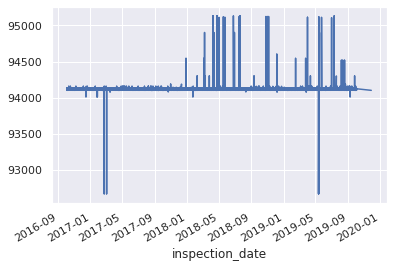

In [25]:
df['business_postal_code'].plot() # Excellent!!! All zipcodes look in proper threshold.

### Grouping by street. I am trying to decide if I can use street name as an aggregated column to make my analysis clustered.

In [26]:
def splitstr(r):
    st = r['business_address']
    return st.split(" ")[-2] if len(st.split(" ")) > 2 else None

In [27]:
df.apply(splitstr, axis='columns')

inspection_date
2019-03-04    Stockton
2019-07-25     Clement
2018-04-18      Kearny
2017-08-18     Mission
2018-04-12       Jones
                ...   
2019-05-06       South
2019-03-14      CAMBON
2019-05-06      Folsom
2019-05-06     Mission
2019-05-06       South
Length: 52732, dtype: object

In [28]:
df['street_name'] = df.apply(splitstr, axis='columns')

In [32]:
street_list = df.groupby('street_name')['inspection_score'].median()  # note the median
street_list = street_list[df['street_name'].value_counts() > 25].sort_values(ascending=False)

In [73]:
# Select the top 12 and bottom 12 street names.
poi = pd.concat(
    [street_list.iloc[[1, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 32]],
     street_list.iloc[range(-12, 0, 1)]]  # last 10, start from 0, skip 1
)
poi.index = [n.title() for n in poi.index]
# not in ['sect', 'Sec, '300', '600', 'Mays', 'Section', 'Rm', 'St']

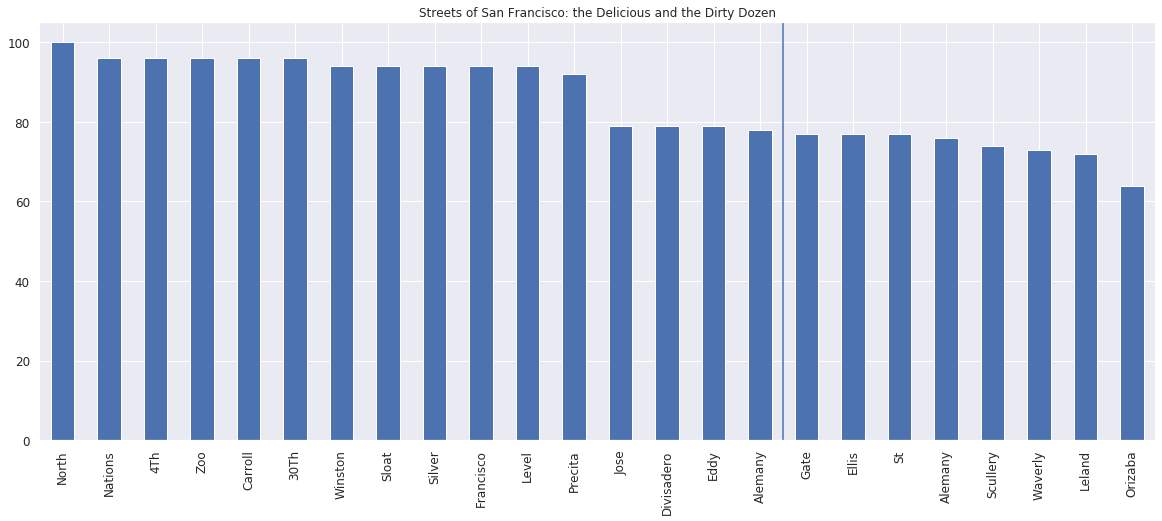

In [75]:
import matplotlib.pyplot as plt
poi.plot.bar(figsize=(20, 10), fontsize=12)
fig = plt.gcf()
fig.subplots_adjust(bottom=0.3)
plt.title('Streets of San Francisco: the Delicious and the Dirty Dozen')
plt.axvline(x=15.5)
plt.savefig("street_list.png")

### It is nice to see streets that are cleaner however it is not really providing me good info. One great thing about this is restaurants typically on 4th street are more sanitary. This is grood news because I live close.

### Delete unused columns to have a smaller data set

In [77]:
df

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_score,inspection_type,violation_id,violation_description,risk_category,Neighborhoods_(old),Police_Districts,Supervisor_Districts,Fire_Prevention_Districts,Zip_Codes,Analysis_Neighborhoods,street_name
inspection_date,,,,,,,,,,,,,,,,,,,,,,,
2019-03-04,69618,Fancy Wheatfield Bakery,1362 Stockton St,San Francisco,CA,94133,NaN,NaN,NaN,NaN,69618_20190304,NaN,Complaint,69618_20190304_103130,Inadequate sewage or wastewater disposal,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN,Stockton
2019-07-25,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,NaN,NaN,NaN,1.415724e+10,97975_20190725,96.0,Routine - Unscheduled,97975_20190725_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN,Clement
2018-04-18,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,NaN,NaN,NaN,NaN,69487_20180418,88.0,Routine - Unscheduled,69487_20180418_103119,Inadequate and inaccessible handwashing facili...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN,Kearny
2017-08-18,91044,Chopsticks Restaurant,4615 Mission St,San Francisco,CA,94112,NaN,NaN,NaN,NaN,91044_20170818,NaN,Non-inspection site visit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mission
2018-04-12,85987,Tselogs,552 Jones St,San Francisco,CA,94102,NaN,NaN,NaN,NaN,85987_20180412,94.0,Routine - Unscheduled,85987_20180412_103132,Improper thawing methods,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN,Jones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-06,89569,Blue Bottle Coffee,2 South Park,San Francisco,CA,94107,NaN,NaN,NaN,NaN,89569_20190506,80.0,Routine - Unscheduled,89569_20190506_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN,South
2019-03-14,99764,POKE KANA,65 CAMBON Dr,San Francisco,CA,94132,NaN,NaN,NaN,NaN,99764_20190314,NaN,New Ownership - Followup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAMBON
2019-05-06,84541,Philz Coffee,300 Folsom St,San Francisco,CA,94105,NaN,NaN,NaN,NaN,84541_20190506,92.0,Routine - Unscheduled,84541_20190506_103133,Foods not protected from contamination,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN,Folsom


### How far back do the inspections go?

#### Since I already converted the date field into index, I can not query the date anymore. So I make a derived date field and add it to a new field

In [80]:
df['derived_inspection_date'] = df['inspection_id'].str.split('_').str[1]

In [81]:
# Format as date
df['derived_inspection_date']=pd.to_datetime(df['derived_inspection_date'],format='%Y-%m-%d')

In [82]:
print("Most recent inspection:", df['derived_inspection_date'].max())  
print("Oldest inspection:", df['derived_inspection_date'].min())   

# Data set has values dating back to 2016 until November of last year. This is when Covid struck and restaurant inspections were temporarily discontinued. 
# This is one of the challenging parts of the projects, the limited data set and an abrupt intervention.

Most recent inspection: 2019-11-28 00:00:00
Oldest inspection: 2016-10-04 00:00:00


In [84]:
# There are few unused columns, lets get rid of those at the same time
df.drop(['Neighborhoods_(old)',  'Police_Districts', 'Supervisor_Districts', 'Fire_Prevention_Districts', 'Zip_Codes', 'Analysis_Neighborhoods'], axis = 1, inplace = True) 
df.head()

,business_id,business_name,business_address,business_postal_code,inspection_id,inspection_score,inspection_type,violation_id,violation_description,risk_category,street_name,derived_inspection_date
inspection_date,,,,,,,,,,,,
2019-03-04,69618,Fancy Wheatfield Bakery,1362 Stockton St,94133,69618_20190304,NaN,Complaint,69618_20190304_103130,Inadequate sewage or wastewater disposal,Moderate Risk,Stockton,2019-03-04
2019-07-25,97975,BREADBELLY,1408 Clement St,94118,97975_20190725,96.0,Routine - Unscheduled,97975_20190725_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,Clement,2019-07-25
2018-04-18,69487,Hakkasan San Francisco,1 Kearny St,94108,69487_20180418,88.0,Routine - Unscheduled,69487_20180418_103119,Inadequate and inaccessible handwashing facili...,Moderate Risk,Kearny,2018-04-18
2017-08-18,91044,Chopsticks Restaurant,4615 Mission St,94112,91044_20170818,NaN,Non-inspection site visit,NaN,NaN,NaN,Mission,2017-08-18
2018-04-12,85987,Tselogs,552 Jones St,94102,85987_20180412,94.0,Routine - Unscheduled,85987_20180412_103132,Improper thawing methods,Moderate Risk,Jones,2018-04-12


### Monthly Average Inspection scores for 2019

In [88]:
df['inspection_score']['2019'].notnull().resample('M').mean()

#It is quite consitent, there is not seasonality in the score means. This is looking at violation and month level.

inspection_date
2019-01-31    0.744772
2019-02-28    0.760571
2019-03-31    0.717624
2019-04-30    0.784767
2019-05-31    0.751656
2019-06-30    0.739806
2019-07-31    0.742210
2019-08-31    0.700343
2019-09-30    0.741520
2019-10-31    0.748858
2019-11-30    0.000000
Freq: M, Name: inspection_score, dtype: float64

### What is the max number of visits per day for the Health Department?

In [94]:
df['inspection_id']['2019'].notnull().resample('D').count().max

#In a single day? I do not know how many inspectors are working but an impressive number. This is after the data cleaning.

<bound method Series.max of inspection_date
2019-01-02    88
2019-01-03    77
2019-01-04    63
2019-01-05     0
2019-01-06     0
              ..
2019-11-24     0
2019-11-25     0
2019-11-26     0
2019-11-27     0
2019-11-28     1
Freq: D, Name: inspection_id, Length: 331, dtype: int64>

### Charts

### Average monthly inspection scores for 2018 

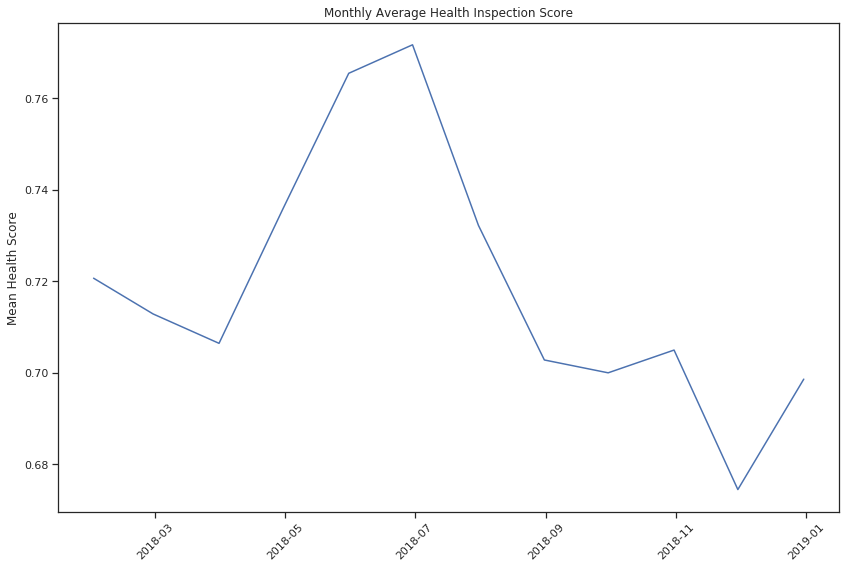

In [96]:
sns.set(rc={'figure.figsize':(14,9)})
sns.set_style("ticks")
# Making it a bit larger to view better

df_plot = df['inspection_score']['2018'].notnull().resample('M').mean()
plt.plot(df_plot)
plt.title('Monthly Average Health Inspection Score')
plt.ylabel('Mean Health Score')
plt.xticks(rotation=45)
plt.show()

# I checked other years for seasonality but did not notice anything.

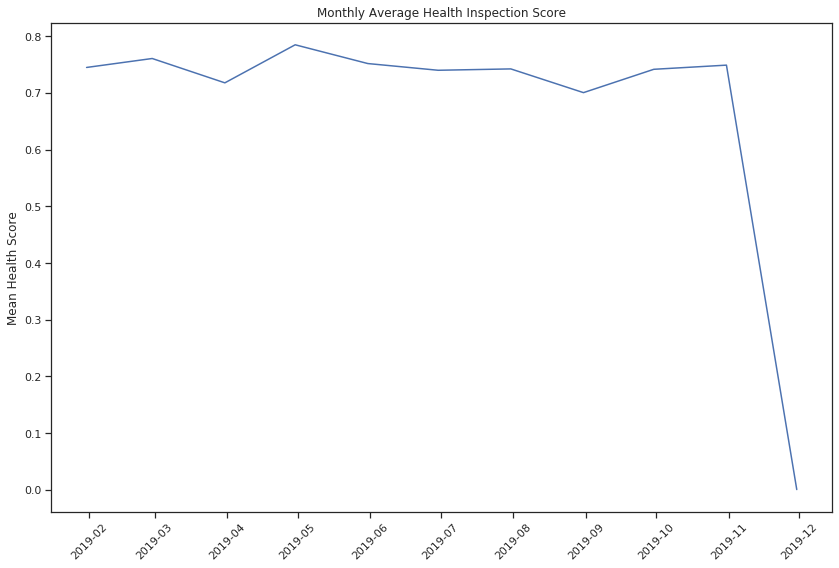

In [97]:
sns.set(rc={'figure.figsize':(14,9)})
sns.set_style("ticks")
# Making it a bit larger to view better

df_plot = df['inspection_score']['2019'].notnull().resample('M').mean()
plt.plot(df_plot)
plt.title('Monthly Average Health Inspection Score')
plt.ylabel('Mean Health Score')
plt.xticks(rotation=45)
plt.show()

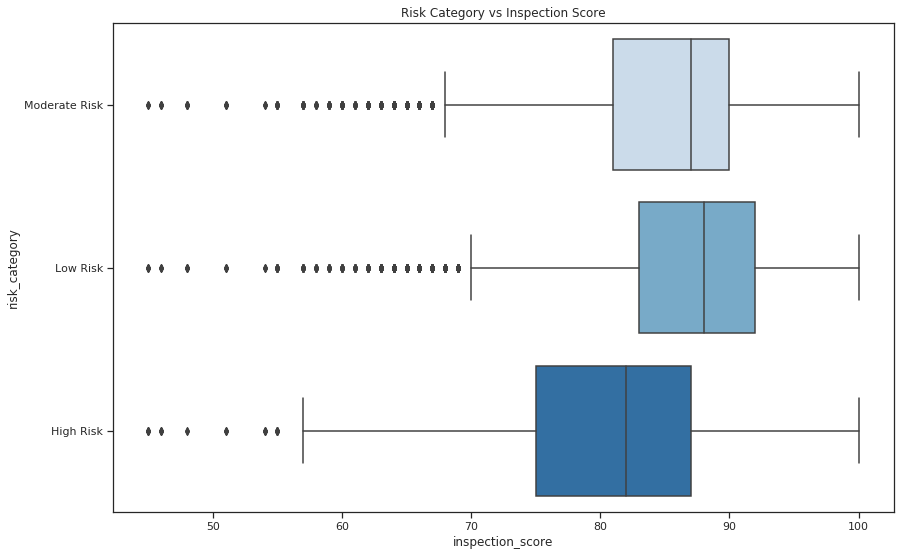

In [102]:
#Interquartile range of the inspection score versus risk category
sns_plot = sns.boxplot( y=df['risk_category'], x=df['inspection_score'], palette='Blues');
plt.title('Risk Category vs Inspection Score')
plt.show()
fig = sns_plot.get_figure()
fig.savefig("Risk_Category_vs_Inspection_Score.png")

### Risk category vs Inspection score is an interesting correlation. First I would like to know more about the outlier therefore a boxplot seems like the best choice. I specifically used shades of blue to see the differences within boxplots for each risk category. Let's analyze and start with the Low risk category. From a first glance, it looks typical. It has the smallest interquartile range with the highest medium of all the categories. This is expected by definition. It means scoring system is directly related with the degrees in risk category. Also the bottom of the IQ3 is ~70 which is very close to the overall medium as well as monthly mean. There is only a small variance. One thing to notice is the number of violations that are outliers.It is the highest of all categories. My hypothesis is that restaurants that receive a low score during an unannounced visit can correct the violations and pay a fine of `199` dollars to get reinspected within 30 days. This is very interesting. Think for a second, restarants scored low during an unexpected visit but were able to rememediate within 30 days. What is the gurantee they are obeying by the rules the other 11 months? On the other hand, the category is low risk and I have been dinged for a low risk item before for not having a "employees must their hands before returning to work" sign in the bathrooms. Maybe the situation is not that bad.<br\> Moderate risk category has the tightest IQR of all categories. It also have a fair share of th eoutlier. I think this is the category we need to be worried about the most. From a quick search it looks like the range of violations are from "Inadequate sewage or wastewater disposal" and "Inadequately cleaned or sanitized food contact surfaces" and all the way to "Improper thawing methods". These are quite serious offenses and can make someone very sick. I think the most scariest thing is that moderate risk's median is also quite large. <br\> Finally, the high risk category. It has very few outlier which is good news. This is the most dangerous to human health. Its IQR is the largest and one thing I am most worried is that it has has a max value of 100. This means even if you are dining at a 100 score restaurant there is a chance that they had a high risk violation before and corrected it. This in my opinion make s track report of a inspection score of 90 and above much more important.

# Before I continue with visually understanding the data set, I need to create my master golden copy data set. In order to do so I will need to update the lat and long, clean the data set, parse street names and create derived neighboorhood columns. Next 2_FindLocations.